Note that to run this notebook you should first download the multivariate datasets from the UEA repository and unzip them into the ../data directory: http://www.timeseriesclassification.com/dataset.php

In [19]:
from sktime.utils.load_data import load_from_tsfile_to_dataframe
import time
import pickle
import os
import numpy as np
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.metrics import gamma_soft_dtw

In [20]:
datasets = ['ArticularyWordRecognition',
'AtrialFibrillation',
'BasicMotions',
'CharacterTrajectories',
'Cricket',
'DuckDuckGeese',
'EigenWorms',
'Epilepsy',
'ERing',
'EthanolConcentration',
'FaceDetection',
'FingerMovements',
'HandMovementDirection',
'Handwriting',
'Heartbeat',
'InsectWingbeat',
'JapaneseVowels',
'Libras',
'LSST',
'MotorImagery',
'NATOPS',
'PEMS-SF',
'PenDigits',
'PhonemeSpectra',
'RacketSports',
'SelfRegulationSCP1',
'SelfRegulationSCP2',
'SpokenArabicDigits',
'StandWalkJump',
'UWaveGestureLibrary']

In [21]:
irregular_datasets = ['JapaneseVowels',
                      'CharacterTrajectories',
                      'SpokenArabicDigits'
                     ]

In [22]:
large_datasets =  ['DuckDuckGeese',
  'InsectWingbeat',
  'PEMS-SF', 
  'FaceDetection',
  'MotorImagery',
  'Handwriting',
  'Heartbeat',
  'PenDigits',
  'PhonemeSpectra',
  'LSST',
  'EigenWorms',
  'FingerMovements',
  'EthanolConcentration',
  'SelfRegulationSCP2',]

In [23]:
def ts_df_to_array(ts_df, index):
    return np.array([ts_df.iloc[index].iloc[i].values for i in range(len(ts_df.iloc[0]))])

In [24]:
def ts_df_to_arrays(ts_df, swapaxes=False):
    arrays=[]
    for index in range(len(ts_df)):
        array = ts_df_to_array(ts_df, index)
        if swapaxes:
            arrays.append(np.swapaxes(array,0,1))
        else:
            arrays.append(array)
    return np.array(arrays)

In [25]:
resampling_iterations = 1
n_neighbors = 1

augmented_accuracies = {}
for dataset_name in datasets:
    augmented_accuracies[dataset_name] = {}
    if dataset_name in large_datasets + irregular_datasets:
        continue
    num_synthetic_ts = 1000
    dba_iters = 5
    limit_N = False

    print("-----------")
    start = time.process_time()
    print(dataset_name)
    train_x, train_y = load_from_tsfile_to_dataframe("../data/%s/%s_TRAIN.ts" % (dataset_name, dataset_name)) 
    test_x, test_y = load_from_tsfile_to_dataframe("../data/%s/%s_TEST.ts" % (dataset_name, dataset_name))
    
    train_x = ts_df_to_arrays(train_x, swapaxes=True)       
    test_x = ts_df_to_arrays(test_x, swapaxes=True)
    
    num_replicates = train_x.shape[0]
    print("# replicates: %d" % (num_replicates))
    num_dimensions = train_x.shape[2]
    print("# dimensions: %d" % (num_dimensions))
    len_series = train_x.shape[1]
    print("length of series: %d" % (len_series))
    num_classes = len(np.unique(train_y))
    print("# classes: %d" % (num_classes))
    total_size = num_replicates*num_dimensions*len_series
    print("total 'size': %d" % (total_size))

    synthetic_x_train = pickle.load(open("../syntheticdata/%s_softdtw_synthetic_x_train_%d_%d_%s.pkl" % (dataset_name, num_synthetic_ts, dba_iters, str(limit_N)), 'rb'))
    synthetic_y_train = pickle.load(open("../syntheticdata/%s_softdtw_synthetic_y_train_%d_%d_%s.pkl" % (dataset_name, num_synthetic_ts, dba_iters, str(limit_N)), 'rb'))
    
    gamma = gamma_soft_dtw(train_x)

    # make predictions on the test set and record the accuracy
    knn = KNeighborsTimeSeriesClassifier(n_neighbors=n_neighbors, metric='softdtw', metric_params={'gamma': gamma})
    knn.fit(train_x, train_y)
    preds = knn.predict(test_x)
    baseline_accuracy = np.mean(preds == test_y)
    print("Baseline accuracy: %f" % (baseline_accuracy))
    augmented_accuracies[dataset_name][-1] = baseline_accuracy

    # loop over desired augmentation degree # 0 0.25 0.5 1.0
    for augmentation_degree in [0, 0.25, 0.5, 1.0, 4.0]:
        augmented_accuracies[dataset_name][augmentation_degree] = []
        print("Augmentation degree: %f" % augmentation_degree)
        # loop over resampling iterations
        for resampling_iteration in range(resampling_iterations):
            # find highest represented class, save this number
            labels, counts = np.unique(train_y, return_counts=True)
            max_counts = np.max(counts)
            # find the number of synthetic examples you need to add to balance
            balance_counts = max_counts - counts
            # loop over all labels
            synthetic_samples = []
            synthetic_labels = []
            for label, balance_count in zip(labels, balance_counts):
                synthetic_data = synthetic_x_train[synthetic_y_train == label]
                
                # compute the number of synthetic samples to choose based on balance_count and augmentation_degree
                samples_to_draw = balance_count + int(augmentation_degree * max_counts)
                
                # randomly sample the synthetic data
                indices = np.arange(len(synthetic_data))
                random_indices = np.random.choice(indices, size=samples_to_draw, replace=False)
                random_synthetic_samples = synthetic_data[random_indices]
                
                # add synthetic samples for this label
                synthetic_samples += list(random_synthetic_samples)
                synthetic_labels += [label]*samples_to_draw
            
            # augment training set with all synthetic samples
            augmented_train_x = np.array(list(train_x) + list(synthetic_samples))
            augmented_train_y = np.array(list(train_y) + list(synthetic_labels))
            
            gamma = gamma_soft_dtw(augmented_train_x)

            # make predictions on the test set and record the accuracy
            knn = KNeighborsTimeSeriesClassifier(n_neighbors=n_neighbors, metric='softdtw', metric_params={'gamma': gamma})
            knn.fit(augmented_train_x, augmented_train_y)
            preds = knn.predict(test_x)
            augmented_accuracy = np.mean(preds == test_y)
            print("Augmented accuracy: %f" % (augmented_accuracy))
            augmented_accuracies[dataset_name][augmentation_degree].append(augmented_accuracy)

    print("Time (s): %f" % (time.process_time() - start))
    print("-----------")

-----------
ArticularyWordRecognition
# replicates: 275
# dimensions: 9
length of series: 144
# classes: 25
total 'size': 356400
Baseline accuracy: 0.970000
Augmentation degree: 0.000000
Augmented accuracy: 0.970000
Augmentation degree: 0.250000
Augmented accuracy: 0.980000
Augmentation degree: 0.500000
Augmented accuracy: 0.973333
Augmentation degree: 1.000000
Augmented accuracy: 0.980000
Augmentation degree: 4.000000
Augmented accuracy: 0.980000
Time (s): 4890.890625
-----------
-----------
AtrialFibrillation
# replicates: 15
# dimensions: 2
length of series: 640
# classes: 3
total 'size': 19200
Baseline accuracy: 0.400000
Augmentation degree: 0.000000
Augmented accuracy: 0.400000
Augmentation degree: 0.250000
Augmented accuracy: 0.333333
Augmentation degree: 0.500000
Augmented accuracy: 0.333333
Augmentation degree: 1.000000
Augmented accuracy: 0.266667
Augmentation degree: 4.000000
Augmented accuracy: 0.266667
Time (s): 265.281250
-----------
-----------
BasicMotions
# replicates: 

KeyboardInterrupt: 

In [26]:
pickle.dump(augmented_accuracies, open("../results/augmented_accuracies_softdtw_%d.pkl" % (resampling_iterations), 'wb'))

In [31]:
aa = pickle.load(open("../results/augmented_accuracies_softdtw_1.pkl", 'rb'))

In [121]:
improved_datasets = ['BasicMotions', 'Epilepsy', 'HandMovementDirection', 'RacketSports']
degraded_datasets = ['AtrialFibrillation']
neutral_datasets = ['ArticularyWordRecognition', 'ERing', 'NATOPS', 'UWaveGestureLibrary', 'SelfRegulationSCP1', 'Libras', 'Cricket', 'StandWalkJump']

In [122]:
import seaborn as sns
sns.set()
sns.set(font_scale=2)
sns.set_style('whitegrid')

In [123]:
figsize=(10,6)

Text(0, 0.5, '1-NN classifier test set accuracy')

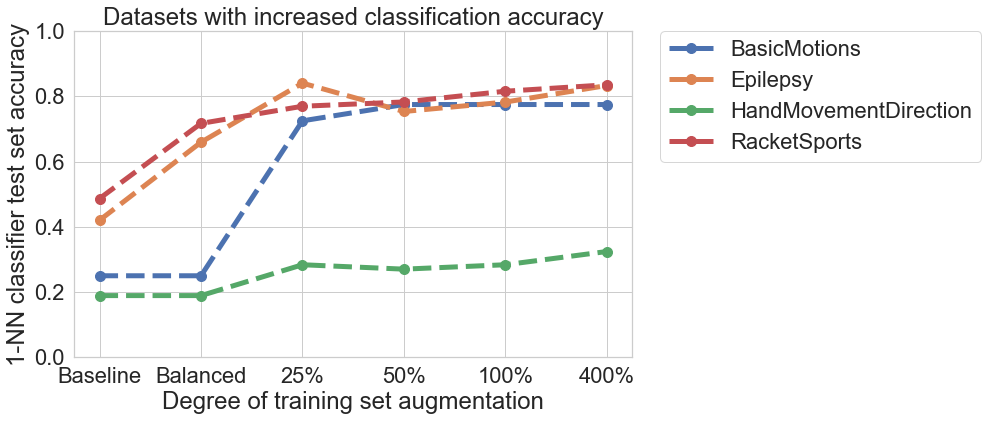

In [124]:
fig, ax = plt.subplots(figsize=figsize)
for key in new_aa.keys():
    if not key in improved_datasets:
        continue
    l = list(new_aa[key].values())
    y = [l[0]] + [item for sublist in l[1:] for item in sublist]
    plt.plot(range(len(y)), y, '--o', label=key, linewidth=5.0, markersize=10.0)
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  
plt.title("Datasets with increased classification accuracy")
ax.set_xticklabels(["?", "Baseline", "Balanced", "25%", "50%", "100%", "400%"])
plt.xlabel("Degree of training set augmentation")
plt.ylabel("1-NN classifier test set accuracy")

Text(0, 0.5, '1-NN classifier test set accuracy')

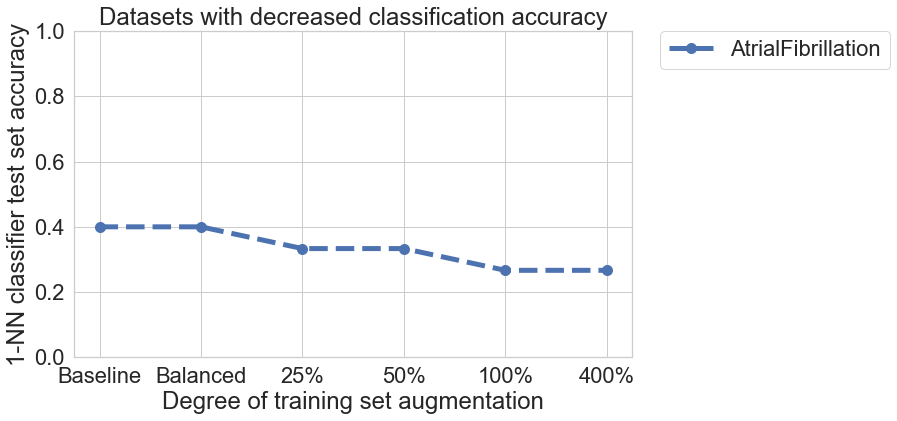

In [125]:
fig, ax = plt.subplots(figsize=figsize)
for key in new_aa.keys():
    if not key in degraded_datasets:
        continue
    l = list(new_aa[key].values())
    y = [l[0]] + [item for sublist in l[1:] for item in sublist]
    plt.plot(range(len(y)), y, '--o', label=key, linewidth=5.0, markersize=10.0)
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  
plt.title("Datasets with decreased classification accuracy")
ax.set_xticklabels(["?", "Baseline", "Balanced", "25%", "50%", "100%", "400%"])
plt.xlabel("Degree of training set augmentation")
plt.ylabel("1-NN classifier test set accuracy")

Text(0, 0.5, '1-NN classifier test set accuracy')

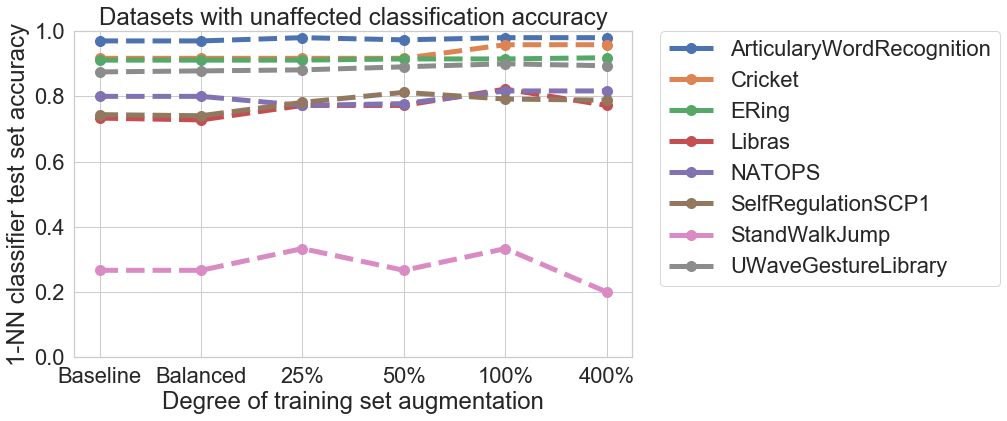

In [127]:
fig, ax = plt.subplots(figsize=figsize)
for key in new_aa.keys():
    if not key in neutral_datasets:
        continue
    l = list(new_aa[key].values())
    y = [l[0]] + [item for sublist in l[1:] for item in sublist]
    plt.plot(range(len(y)), y, '--o', label=key, linewidth=5.0, markersize=10.0)
plt.ylim([0,1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  
plt.title("Datasets with unaffected classification accuracy")
ax.set_xticklabels(["?", "Baseline", "Balanced", "25%", "50%", "100%", "400%"])
plt.xlabel("Degree of training set augmentation")
plt.ylabel("1-NN classifier test set accuracy")